In [1]:
import sys
print(sys.executable)
import os

# Agregar el directorio raíz del proyecto a sys.path
project_root = "/home/javitrucas/TFG"
if project_root not in sys.path:
    sys.path.append(project_root)

/home/javitrucas/miniconda3/envs/tfg/bin/python


In [2]:
# Importaciones necesarias
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix

# Agregar la ruta de los scripts al sistema
sys.path.append(os.path.abspath("../scripts"))

# Importar el modelo y las clases de datasets
from scripts.model import MILModel
from data.datasets.SCStandardMILDataset import SCStandardMILDataset
from data.datasets.MCStandardMILDataset import MCStandardMILDataset
from data.datasets.FalseFrequencyMILDataset import FalseFrequencyMILDataset

/home/javitrucas/miniconda3/envs/tfg/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/javitrucas/miniconda3/envs/tfg/lib/python3.11/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [3]:
# Configuración general
DATA_DIR = "../data/datasets"  # Carpeta donde están los datasets
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# BATCH_SIZE = 1
NUM_EPOCHS = 10
LEARNING_RATE = 0.001
FEATURE_DIM = 2
POOLING_TYPE = "attention"  # Opciones: 'attention', 'mean', 'max'

# Parámetros específicos de los datasets
D = FEATURE_DIM  # Dimensionalidad de los datos
NUM_BAGS = 10  # Número de bolsas
B = 3  # Número de instancias negativas por bolsa
POS_CLASS_PROB = 0.5  # Probabilidad de que una bolsa sea positiva
SEED = 42  # Semilla para reproducibilidad

In [4]:
def train_model(loader, model, criterion, optimizer, epochs=NUM_EPOCHS):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for bag_data, bag_label, instance_labels, adj_mat, mask in loader:
            # Asegurar que las etiquetas tengan dimensión (batch_size, 1)
            bag_data = bag_data.to(DEVICE)
            bag_label = bag_label.unsqueeze(-1).float().to(DEVICE)  # Añadir dimensión
            mask = mask.to(DEVICE) if mask is not None else None

            optimizer.zero_grad()
            predictions, _ = model(bag_data, mask=mask)
            
            # Usar BCELoss con sigmoid manual
            loss = criterion(torch.sigmoid(predictions), bag_label)
            
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss:.4f}")

In [5]:
def evaluate_model(loader, model):
    model.eval()
    all_labels = []
    all_preds = []
    with torch.no_grad():
        for bag_data, bag_label, _, _, mask in loader:
            bag_data = bag_data.to(DEVICE)
            mask = mask.to(DEVICE) if mask is not None else None
            output, _ = model(bag_data, mask=mask)
            preds = (torch.sigmoid(output) > 0.5).float().cpu().squeeze().tolist()
            all_preds.extend(preds if isinstance(preds, list) else [preds])
            all_labels.extend(bag_label.cpu().numpy().tolist())
    
    # Calcular métricas
    accuracy = np.mean(np.array(all_preds) == np.array(all_labels))
    auc = roc_auc_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)
    cm = confusion_matrix(all_labels, all_preds)
    
    print(f"Accuracy: {accuracy:.4f}, AUC: {auc:.4f}, F1-Score: {f1:.4f}")
    print("Confusion Matrix:")
    print(cm)

In [40]:
import matplotlib.pyplot as plt
import torch
import numpy as np

def visualizar_bolsas(dataset, max_bolsas=None):
    """
    Visualiza bolsas de datos en 2D, indicando bolsas positivas/negativas,
    instancias positivas y posibles instancias envenenadas.

    Args:
        dataset: Lista de tuplas (bag_data, bag_label, inst_labels, adj_mat)
        max_bolsas: Número máximo de bolsas a visualizar (opcional)
    """
    num_bolsas = len(dataset) if max_bolsas is None else min(len(dataset), max_bolsas)
    fig, axes = plt.subplots(1, num_bolsas, figsize=(5 * num_bolsas, 5))

    # Asegurar que axes sea iterable
    if num_bolsas == 1:
        axes = [axes]

    for idx in range(num_bolsas):
        bag_data, bag_label, inst_labels, _ = dataset[idx]
        ax = axes[idx]

        # Convertir tensores a numpy para compatibilidad con matplotlib
        bag_data_np = bag_data.numpy()
        inst_labels_np = inst_labels.numpy()

        # Determinar color de la bolsa
        color_bolsa = 'blue' if bag_label.item() == 1 else 'red'
        titulo_bolsa = 'Positiva' if bag_label.item() == 1 else 'Negativa'

        # Dibujar todas las instancias
        ax.scatter(bag_data_np[:, 0], bag_data_np[:, 1], c=color_bolsa, alpha=0.6, label='Instancias')

        # Resaltar instancias positivas y envenenadas
        for i, etiqueta in enumerate(inst_labels_np):
            if etiqueta == 1:
                ax.scatter(bag_data_np[i, 0], bag_data_np[i, 1], c='green', edgecolors='black', s=100, label='Instancia Positiva')
            elif etiqueta == -1:
                ax.scatter(bag_data_np[i, 0], bag_data_np[i, 1], c='purple', edgecolors='black', s=100, label='Instancia Envenenada')

        ax.set_title(f'Bolsa {idx + 1} ({titulo_bolsa})')
        ax.set_xlabel('Dimensión 1')
        ax.set_ylabel('Dimensión 2')
        ax.legend()

    plt.tight_layout()
    plt.show()


SC Standard Dataset

In [ ]:
sc_dataset = SCStandardMILDataset(
    D=FEATURE_DIM,
    num_bags=NUM_BAGS,
    B=B
)

sc_loader = DataLoader(sc_dataset, shuffle=True, collate_fn=sc_dataset.collate_fn)

i=0
for a in sc_dataset:
    print(sc_dataset[i])
    i=i+1

# Visualizar bolsas
visualizar_bolsas(sc_dataset)

(tensor([[-3.6854,  0.6339],
        [-0.9289, -0.5856],
        [-0.3022,  0.8769],
        [-0.1823, -0.0982]]), tensor(1), tensor([1., 0., 0., 0.]), tensor(indices=tensor([], size=(2, 0)),
       values=tensor([], size=(0,)),
       size=(4, 4), nnz=0, dtype=torch.float64, layout=torch.sparse_coo))
(tensor([[ 1.7162, -0.5731],
        [ 2.4797, -8.9292],
        [-0.6848,  1.6705],
        [-1.4663, -0.2449],
        [-0.7496, -1.3968]]), tensor(1), tensor([1., 1., 0., 0., 0.]), tensor(indices=tensor([], size=(2, 0)),
       values=tensor([], size=(0,)),
       size=(5, 5), nnz=0, dtype=torch.float64, layout=torch.sparse_coo))
(tensor([[ 0.5136,  0.7238],
        [ 1.7523,  1.3468],
        [-0.5601,  0.3891],
        [ 0.5019,  0.0338],
        [ 0.1061, -0.0733]]), tensor(1), tensor([1., 1., 0., 0., 0.]), tensor(indices=tensor([], size=(2, 0)),
       values=tensor([], size=(0,)),
       size=(5, 5), nnz=0, dtype=torch.float64, layout=torch.sparse_coo))
(tensor([[-0.9276, -0.4861]

In [34]:
criterion = torch.nn.BCELoss()

# Ejemplo para SCStandard
print("=== Entrenando en SCStandard Dataset ===")
model = MILModel(input_feature_dim=FEATURE_DIM, pooling_type=POOLING_TYPE).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
train_model(sc_loader, model,criterion , optimizer)

print("=== Evaluando en SCStandard Dataset ===")
evaluate_model(sc_loader, model)

=== Entrenando en SCStandard Dataset ===
Epoch 1/10, Loss: 11.0774
Epoch 2/10, Loss: 6.9863
Epoch 3/10, Loss: 7.0088
Epoch 4/10, Loss: 6.6819
Epoch 5/10, Loss: 7.3732
Epoch 6/10, Loss: 6.7368
Epoch 7/10, Loss: 6.6848
Epoch 8/10, Loss: 7.5963
Epoch 9/10, Loss: 7.4327
Epoch 10/10, Loss: 6.4472
=== Evaluando en SCStandard Dataset ===
Accuracy: 0.6000, AUC: 0.6000, F1-Score: 0.5000
Confusion Matrix:
[[4 1]
 [3 2]]


MC Standard Dataset

(tensor([[ 2.1153e+00,  2.0412e+00],
        [ 2.8885e+00,  2.9222e+00],
        [ 1.8836e+00,  2.0953e+00],
        [ 3.0785e+00,  3.1009e+00],
        [-2.3919e-03,  4.9750e-01],
        [-8.0009e-01, -8.7021e-01],
        [-1.0422e+00,  2.0551e-01],
        [ 1.1320e+00,  8.8868e-01],
        [ 4.2346e-01, -2.1183e+00],
        [-6.4688e-01,  8.7404e-01],
        [-1.5792e+00,  2.3247e-01]]), tensor(1), tensor([1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0.]), tensor(indices=tensor([], size=(2, 0)),
       values=tensor([], size=(0,)),
       size=(11, 11), nnz=0, dtype=torch.float64, layout=torch.sparse_coo))
(tensor([[ 1.9677,  1.8312],
        [ 3.0043,  2.9342],
        [ 1.9509,  1.9796],
        [ 2.9278,  2.8763],
        [ 2.1889,  1.9335],
        [ 2.9373,  3.0480],
        [-0.2020,  1.6922],
        [ 0.6754, -0.3172],
        [ 0.7698,  0.4876],
        [-0.5712, -0.9787],
        [ 1.7004, -1.2953]]), tensor(1), tensor([1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0.]), tensor(

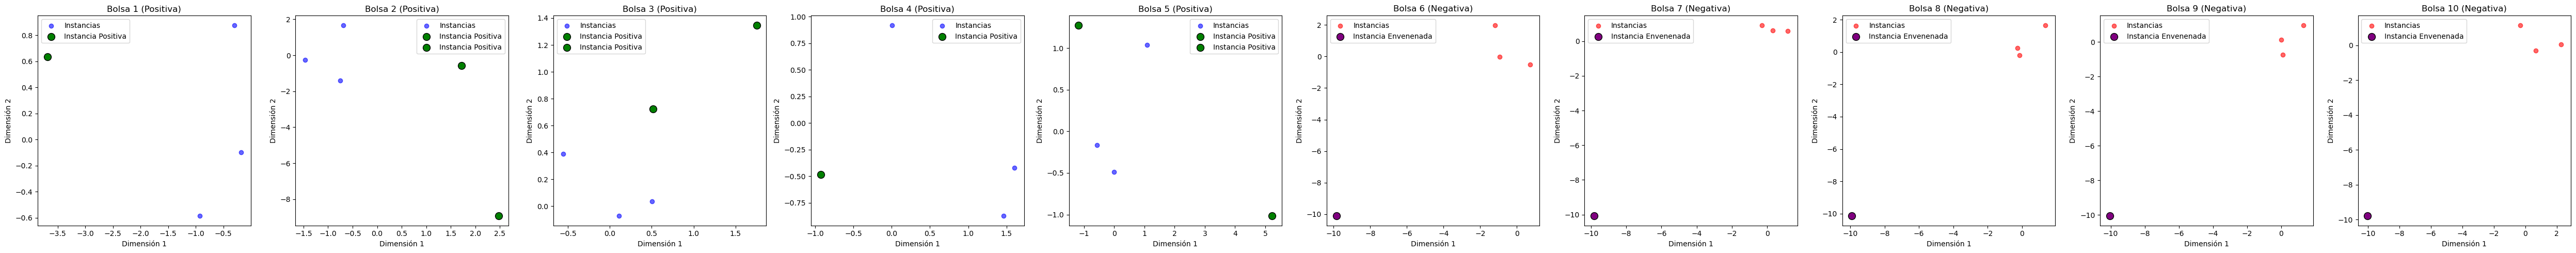

In [41]:
mc_dataset = MCStandardMILDataset(
    D=D,
    num_bags=NUM_BAGS,
    B=B
)

mc_loader = DataLoader(mc_dataset, shuffle=True, collate_fn=mc_dataset.collate_fn)

i=0
for a in mc_dataset:
    print(mc_dataset[i])
    i=i+1

# Visualizar bolsas
visualizar_bolsas(sc_dataset)

In [29]:
criterion = torch.nn.BCELoss()

# Ejemplo para MCStandard
print("=== Entrenando en MCStandard Dataset ===")
model = MILModel(input_feature_dim=D, pooling_type=POOLING_TYPE).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
train_model(mc_loader, model,criterion , optimizer)

print("=== Evaluando en MCStandard Dataset ===")
evaluate_model(mc_loader, model)

=== Entrenando en MCStandard Dataset ===


RuntimeError: The size of tensor a (4) must match the size of tensor b (3) at non-singleton dimension 1

False Frequency Dataset

{'X': tensor([[ 2.0924,  2.0339],
        [ 2.9487,  3.0968],
        [ 0.4330,  0.3035],
        [ 0.0849, -0.9180]]), 'Y': tensor(1), 'y_inst': tensor([1., 1., 0., 0.])}
{'X': tensor([[ 1.9842,  1.9465],
        [ 3.1365,  2.8743],
        [ 0.4402, -1.1075],
        [ 0.2106,  2.0773],
        [-0.8638,  1.1694],
        [ 1.4589,  0.7248],
        [-1.1303,  0.4453]]), 'Y': tensor(1), 'y_inst': tensor([1., 1., 0., 0., 0., 0., 0.])}
{'X': tensor([[ 2.0640,  2.2028],
        [ 2.9168,  3.0338],
        [ 0.9003, -0.8966],
        [-0.0783, -0.5497],
        [-0.2210,  0.5227],
        [-0.7823, -2.1438],
        [-0.6806, -0.2452]]), 'Y': tensor(1), 'y_inst': tensor([1., 1., 0., 0., 0., 0., 0.])}
{'X': tensor([[ 2.0601,  2.0561],
        [ 2.8938,  3.1261],
        [ 0.6894,  2.3627],
        [-0.5494, -1.1350],
        [ 0.1251, -0.5332],
        [-2.0342, -0.3112],
        [ 0.8412, -0.1340],
        [ 0.0760, -0.7035],
        [ 0.2642,  1.1983]]), 'Y': tensor(1), 'y_inst': tensor

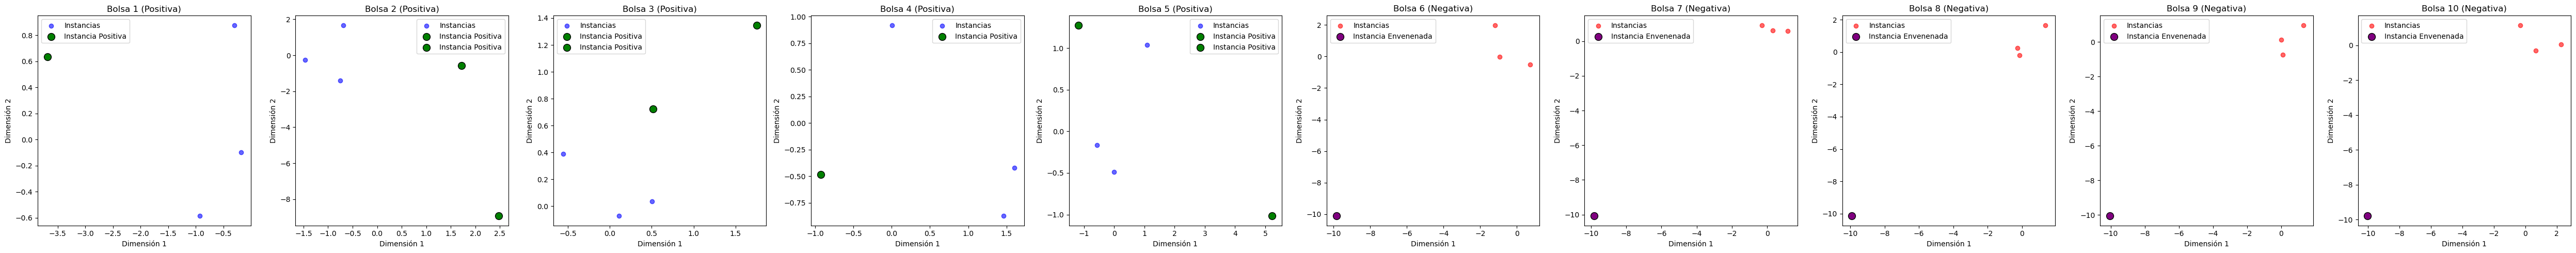

In [42]:
ff_dataset =FalseFrequencyMILDataset(
    D=D,
    num_bags=NUM_BAGS,
    B=B
)

ff_loader = DataLoader(ff_dataset, shuffle=True)

i=0
for a in ff_dataset:
    print(ff_dataset[i])
    i=i+1
    
# Visualizar bolsas
visualizar_bolsas(sc_dataset)

In [32]:
criterion = torch.nn.BCELoss()

# Ejemplo para FalseFrequency
print("=== Entrenando en FalseFrequency Dataset ===")
model = MILModel(input_feature_dim=D, pooling_type=POOLING_TYPE).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
train_model(ff_loader, model,criterion , optimizer)

print("=== Evaluando en FalseFrequency Dataset ===")
evaluate_model(ff_loader, model)

=== Entrenando en FalseFrequency Dataset ===


ValueError: not enough values to unpack (expected 5, got 3)